In [ ]:
! pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle


In [ ]:
! cp kaggle.json ~/.kaggle/


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions download  airbus-ship-detection

100% 28.6G/28.6G [03:28<00:00, 116MB/s]
100% 28.6G/28.6G [03:28<00:00, 147MB/s]


In [2]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

In [ ]:
! unzip /content/airbus-ship-detection.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: train_v2/f9775b70e.jpg  
  inflating: train_v2/f977a470c.jpg  
  inflating: train_v2/f9780bfaf.jpg  
  inflating: train_v2/f9782bdfe.jpg  
  inflating: train_v2/f9785ca49.jpg  
  inflating: train_v2/f9785e462.jpg  
  inflating: train_v2/f97a719d5.jpg  
  inflating: train_v2/f97afa376.jpg  
  inflating: train_v2/f97b85e3e.jpg  
  inflating: train_v2/f97bd0b11.jpg  
  inflating: train_v2/f97bd6b80.jpg  
  inflating: train_v2/f97bfb1b2.jpg  
  inflating: train_v2/f97c8cbbe.jpg  
  inflating: train_v2/f97cdd397.jpg  
  inflating: train_v2/f97d92e1e.jpg  
  inflating: train_v2/f97da9e70.jpg  
  inflating: train_v2/f97e843d3.jpg  
  inflating: train_v2/f97e961f2.jpg  
  inflating: train_v2/f97e96c68.jpg  
  inflating: train_v2/f97f63ae1.jpg  
  inflating: train_v2/f97f80839.jpg  
  inflating: train_v2/f97f83438.jpg  
  inflating: train_v2/f97fab9ad.jpg  
  inflating: train_v2/f97fd4915.jpg  
  inflatin

In [3]:
DATA_DIR = '/content'


In [4]:
! mkdir /content/oussama


mkdir: cannot create directory ‘/content/oussama’: File exists


In [5]:
ROOT_DIR = '/content/oussama'

In [6]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')


fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [20]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip uninstall h5py -y
!pip install tensorflow==1.13.1
!pip install keras==2.0.8
!pip install h5py==2.10.0

Found existing installation: keras 2.8.0
Uninstalling keras-2.8.0:
  Successfully uninstalled keras-2.8.0
Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
Found existing installation: keras-vis 0.4.1
Uninstalling keras-vis-0.4.1:
  Successfully uninstalled keras-vis-0.4.1
Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636
Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92.6 MB 1.2 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 367 kB 56.0 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |██

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 6.2 MB/s 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 5.0 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0


In [7]:
sys.path.append(os.path.join('/content/Mask_RCNN', 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [8]:
train_dicom_dir = os.path.join(DATA_DIR, 'train_v2')
test_dicom_dir = os.path.join(DATA_DIR, 'test_v2')

In [9]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Dec  6  2021 mask_rcnn_coco.h5


In [11]:
class DetectorConfig(Config):    
    # Give the configuration a recognizable name  
    NAME = 'airbus'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 9
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background and ship classes
    
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
    RPN_ANCHOR_SCALES = (8, 16, 32, 64)
    TRAIN_ROIS_PER_IMAGE = 64
    MAX_GT_INSTANCES = 14
    DETECTION_MAX_INSTANCES = 10
    DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_NMS_THRESHOLD = 0.0
    
    STEPS_PER_EPOCH = 15 
    VALIDATION_STEPS = 10 
    
    ## balance out losses
    LOSS_WEIGHTS = {
        "rpn_class_loss": 30.0,
        "rpn_bbox_loss": 0.8,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 1.0,
        "mrcnn_mask_loss": 1.2
    }
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     9
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 9
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 30.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.2}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [12]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

In [13]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1) # to rgb function

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None): # raster to rle coding 
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)): # rle coding to raster
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [14]:
from PIL import Image
from sklearn.model_selection import train_test_split

# hatalı resim listesi
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

train_names = [f for f in os.listdir(train_dicom_dir) if f not in exclude_list]
test_names = [f for f in os.listdir(test_dicom_dir) if f not in exclude_list]

print(len(train_names), len(test_names))

192555 15606


In [15]:
# training dataset
SEGMENTATION = DATA_DIR + '/train_ship_segmentations_v2.csv'
anns = pd.read_csv(SEGMENTATION)
anns.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [21]:
train_names = anns[anns.EncodedPixels.notnull()].ImageId.unique().tolist()
print("Uniq image list containing ships:",np.shape(train_names))

test_size = config.VALIDATION_STEPS * config.IMAGES_PER_GPU # 10*9
image_fps_train, image_fps_val = train_test_split(train_names, test_size=test_size, random_state=42)

print("train:",len(image_fps_train), "val:",len(image_fps_val), "test:",len(test_names))


Uniq image list containing ships: (42556,)
train: 42466 val: 90 test: 15606


In [19]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training our dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('ship', 1, 'Ship')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations.query('ImageId=="' + fp + '"')['EncodedPixels']
            self.add_image('ship', image_id=i, path=os.path.join(train_dicom_dir, fp), 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image = imread(fp)
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
#         print(image_id, annotations)
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                mask[:, :, i] = rle_decode(a)
                class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [22]:
image_fps, image_annotations = train_names, anns
print("Uniq image list containing ships:",np.shape(image_fps))
print("Train ship segmentations csv file:",np.shape(image_annotations))

Uniq image list containing ships: (42556,)
Train ship segmentations csv file: (231723, 2)


Image original size: 768


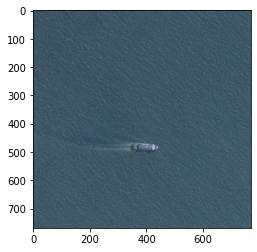

In [23]:
ds = imread(os.path.join(train_dicom_dir, image_fps[0])) # read  image from filepath 
plt.imshow(ds)

# Original image size: 768 x 768
ORIG_SIZE = ds.shape[0]
print("Image original size:",ORIG_SIZE)

In [24]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

KeyboardInterrupt: ignored

In [ ]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()